# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random

## Sales

In [2]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` order by sku, site_id, year, week desc'
sales_df = utils.bq_to_dataframe(query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:01:18.696232
Mem. usage decreased to 126.19 Mb (42.2% reduction)


In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576272 entries, 0 to 3576271
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Week         int8   
 1   Year         int16  
 2   Site_ID      int16  
 3   SKU          int32  
 4   Sales_QTY    float32
 5   Season_Year  object 
 6   Vendor_ID    object 
 7   Vendor_Name  object 
dtypes: float32(1), int16(2), int32(1), int8(1), object(3)
memory usage: 126.2+ MB


## Stock

In [4]:
query = "SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_stock_weekly` order by SKU, site_id, year, week desc"
stock_df = utils.bq_to_dataframe(query, verbose=True).pipe(utils.reduce_memory_usage)


********************
Query Duration:  0:00:26.619558
Mem. usage decreased to 20.42 Mb (52.5% reduction)


In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127075 entries, 0 to 1127074
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Week     1127075 non-null  int8   
 1   Year     1127075 non-null  int16  
 2   Site_ID  1127075 non-null  object 
 3   SKU      1127075 non-null  int32  
 4   Stock    1127075 non-null  float32
dtypes: float32(1), int16(1), int32(1), int8(1), object(1)
memory usage: 20.4+ MB


In [6]:
stock_df.sort_values(by=['SKU', 'Site_ID','Year','Week'])

,Week,Year,Site_ID,SKU,Stock
46,6,2019,g116,3082255,53.0
45,7,2019,g116,3082255,53.0
44,8,2019,g116,3082255,53.0
43,9,2019,g116,3082255,53.0
42,10,2019,g116,3082255,49.0
...,...,...,...,...,...
1127073,50,2020,g116,1290002601,3.0
1127072,51,2020,g116,1290002601,2.0
1127071,52,2020,g116,1290002601,3.0
1127070,53,2020,g116,1290002601,3.0


# Merge Sales and Stock Data

In [7]:
# Adjust data types for merge
sales_df['Site_ID'] = 'g' + sales_df.Site_ID.astype(str)

In [8]:
df = sales_df.merge(stock_df, how='left', on=['SKU', 'Week', 'Year', 'Site_ID'])
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
...,...,...,...,...,...,...,...,...,...
3576267,49,2020,g101,1290002601,1.0,9999,0000948925,Tateossian Ltd.,NaN
3576268,53,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0
3576269,52,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0
3576270,51,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,2.0


# SKU, Vendor, Season_Year - Data Exploration

In [9]:
df.SKU.drop_duplicates().count()

6637

In [10]:
df[['SKU', 'Season_Year', 'Vendor_Name']].drop_duplicates().Season_Year.value_counts()

9999    3907
2020    2479
2021     189
2019      33
2018      23
2017       5
2016       1
Name: Season_Year, dtype: int64

In [11]:
print('Number of vendors: ', df.Vendor_Name.drop_duplicates().count())
print('\nSummary:\n ',df[['SKU', 'Season_Year', 'Vendor_Name']].drop_duplicates().Vendor_Name.value_counts().head(25))

Number of vendors:  112

Summary:
  RALPH LAUREN GERMANY GMBH     1000
Tommy Hilfiger Europe BV       665
BRAX                           502
Zimmerli Textil AG             269
Eton AB                        267
Diesel S.p.A.                  240
Hanro AG                       228
Isa Seta SPA                   216
Fashion Box Switzerland AG     198
Strellson AG                   183
Fibretex SPA                   165
Calvin Klein Europe BV         161
FOSTER SPA                     160
Corinus AG Fashion Group       135
Dagsmejan Ventures AG          119
Confezioni Damap SRL           117
Allsaints Wholesale Ltd.       113
RAGMAN TEXTILHANDEL GMBH       107
Tiger of Sweden                104
Paul Smith Ltd                  94
Swiss Hest GmbH                 84
Derek Rose Ltd                  69
Orlebar Brown Ltd               60
Marc Betschmann GmbH            56
Hugo Boss (Schweiz) AG          53
Name: Vendor_Name, dtype: int64


# Sales - Data Exploration

In [12]:
# Overall
print('Mean: ', df.Sales_QTY.mean())
print('Std.: ', df.Sales_QTY.std())
print('\nDeciles:\n', df.Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.17206438
Std.:  0.8036046

Deciles:
 0.0   -30.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     0.0
1.0    65.0
Name: Sales_QTY, dtype: float64


In [13]:
# Basic-Articles
print('Mean: ', df.loc[df.Season_Year == '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year == '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year == '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.17972478
Std.:  0.83038545

Deciles:
 0.0   -30.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     1.0
1.0    65.0
Name: Sales_QTY, dtype: float64


In [14]:
# Seasonal Articles
print('Mean: ', df.loc[df.Season_Year != '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year != '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year != '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.08412604
Std.:  0.36746657

Deciles:
 0.0    -3.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     0.0
1.0    20.0
Name: Sales_QTY, dtype: float64


In [15]:
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN
...,...,...,...,...,...,...,...,...,...
3576267,49,2020,g101,1290002601,1.0,9999,0000948925,Tateossian Ltd.,NaN
3576268,53,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0
3576269,52,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0
3576270,51,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,2.0


In [16]:
df['Year_Week'] = df.Year.astype(str) + df.Week.astype(str)
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock,Year_Week
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201052
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201051
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201050
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201049
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201048
...,...,...,...,...,...,...,...,...,...,...
3576267,49,2020,g101,1290002601,1.0,9999,0000948925,Tateossian Ltd.,NaN,202049
3576268,53,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0,202053
3576269,52,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0,202052
3576270,51,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,2.0,202051


# Plot Time-Series

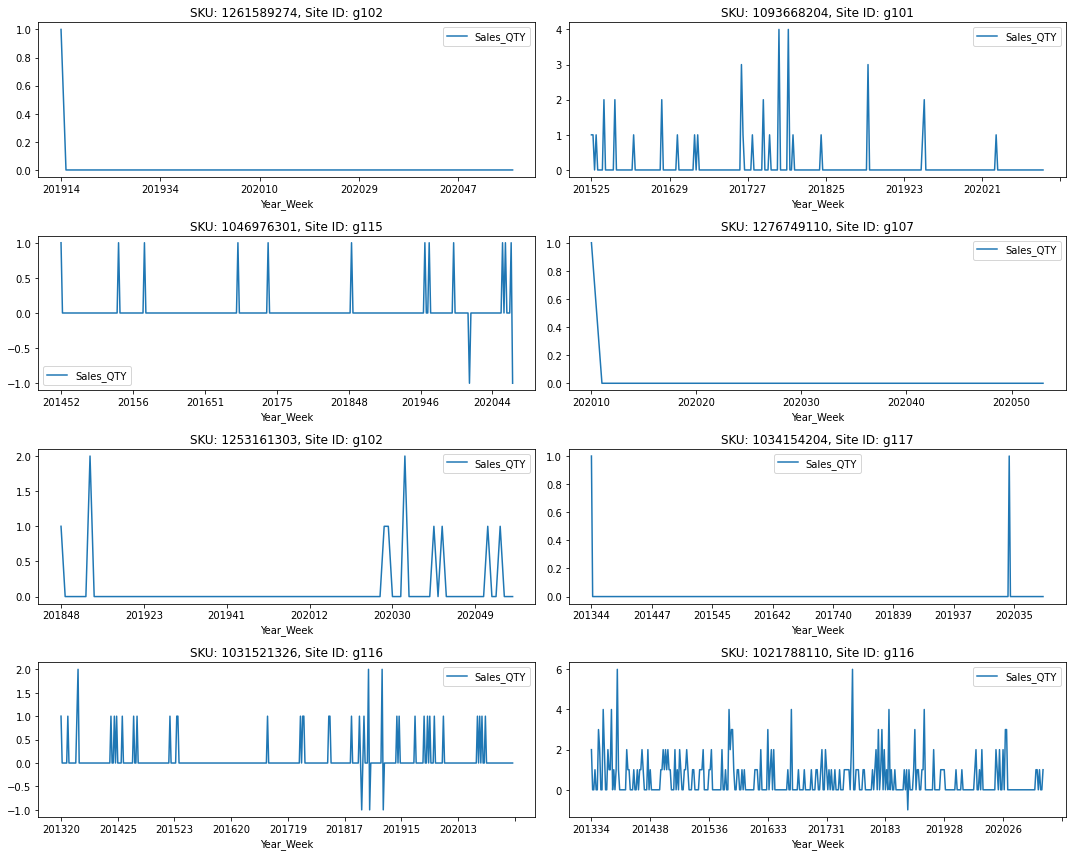

In [17]:
n_series = 8

# Sample n random occurences
samples = df[['SKU', 'Site_ID']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for article, site in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])
    ax_idx += 1
    
plt.tight_layout()
plt.show()

# Plot Time Series for Top-Sellers

In [18]:
# Get SKU / Store combinations with a mean sale greater a threshold
top_sellers_mean = df[['Site_ID', 'SKU', 'Sales_QTY']].groupby(['Site_ID', 'SKU']).mean() 
top_sellers_mean = top_sellers_mean.loc[top_sellers_mean.Sales_QTY > 0.2]
top_sellers_mean

Sales_QTY
Site_ID SKU                  
g101    2069466      0.202186
        2069474      1.005254
        2069482      1.012195
        2069490      0.262324
        2069505      0.416376
...                       ...
g590    1288779503   0.666667
        1288934412   0.500000
        1288934413   1.000000
        1288934415   0.500000
        1289959504   1.000000

[5559 rows x 1 columns]

In [19]:
# Get SKU / Store combinations which timeseries is longer than a threshold
top_sellers_length = df[['Site_ID', 'SKU', 'Sales_QTY']].loc[df.Sales_QTY > 0].groupby(['Site_ID', 'SKU']).count()
top_sellers_length = top_sellers_length.loc[top_sellers_length.Sales_QTY > 8]
top_sellers_length

Sales_QTY
Site_ID SKU                  
g101    2069466            55
        2069474           205
        2069482           158
        2069490            62
        2069505            99
...                       ...
g590    1282538101         11
        1282538301          9
        1283465804          9
        1284233102          9
        1284234802          9

[7506 rows x 1 columns]

In [20]:
# select only SKUs that meet both requirements 
top_sellers = top_sellers_mean.merge(top_sellers_length, how='inner', on=['Site_ID', 'SKU'])
top_sellers = top_sellers.reset_index(drop=False)[['Site_ID', 'SKU']]
top_sellers

,Site_ID,SKU
0,g101,2069466
1,g101,2069474
2,g101,2069482
3,g101,2069490
4,g101,2069505
...,...,...
1934,g590,1282538101
1935,g590,1282538301
1936,g590,1283465804
1937,g590,1284233102


In [21]:
# Print number of articles that are top sellers (it at least one store)
len(top_sellers.SKU.drop_duplicates())

742

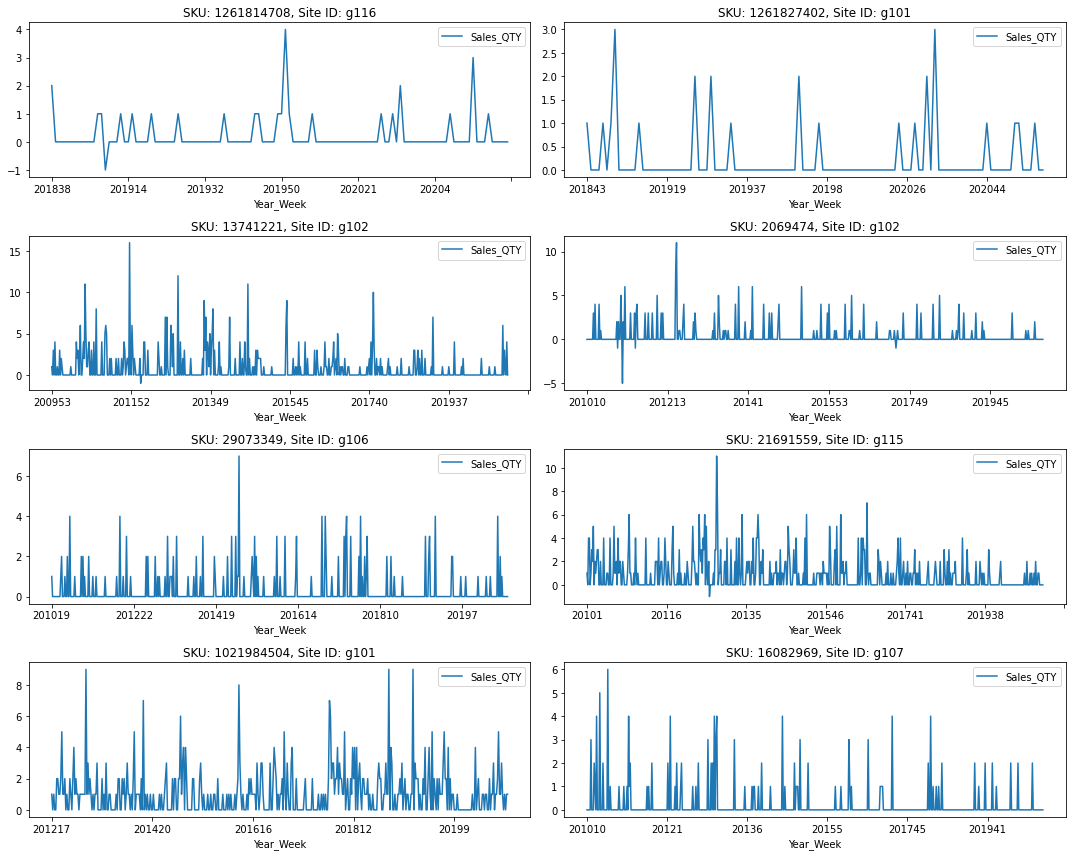

In [22]:
n_series = 8


# Sample n random occurences
samples = top_sellers.sample(n=n_series, random_state=1).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for site, article in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])

    ax_idx += 1
    
plt.tight_layout()
plt.show()


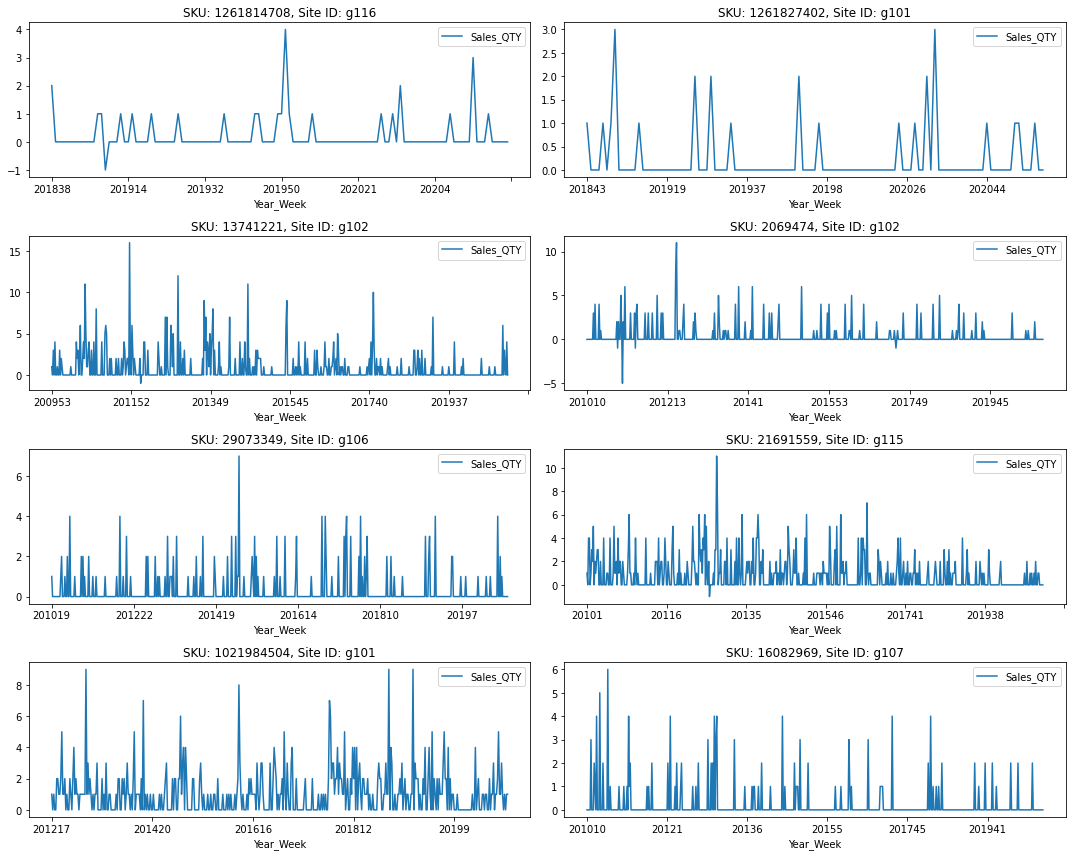

In [23]:
n_series = 8


# Sample n random occurences
samples = top_sellers.sample(n=n_series, random_state=1).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for site, article in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])

    ax_idx += 1
    
plt.tight_layout()
plt.show()


In [24]:
# Basic-Articles
print('Mean: ', df.loc[df.Season_Year == '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year == '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year == '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.17972478
Std.:  0.83038545

Deciles:
 0.0   -30.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     1.0
1.0    65.0
Name: Sales_QTY, dtype: float64


In [25]:
# Seasonal Articles
print('Mean: ', df.loc[df.Season_Year != '9999'].Sales_QTY.mean())
print('Std.: ', df.loc[df.Season_Year != '9999'].Sales_QTY.std())
print('\nDeciles:\n', df.loc[df.Season_Year != '9999'].Sales_QTY.quantile(np.arange(0, 1.1, 0.1)))

Mean:  0.08412604
Std.:  0.36746657

Deciles:
 0.0    -3.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     0.0
1.0    20.0
Name: Sales_QTY, dtype: float64


In [26]:
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock,Year_Week
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201052
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201051
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201050
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201049
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201048
...,...,...,...,...,...,...,...,...,...,...
3576267,49,2020,g101,1290002601,1.0,9999,0000948925,Tateossian Ltd.,NaN,202049
3576268,53,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0,202053
3576269,52,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0,202052
3576270,51,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,2.0,202051


In [27]:
df['Year_Week'] = df.Year.astype(str) + df.Week.astype(str)
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Stock,Year_Week
0,52,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201052
1,51,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201051
2,50,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201050
3,49,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201049
4,48,2010,g101,2069466,0.0,9999,0000194449,Hanro AG,NaN,201048
...,...,...,...,...,...,...,...,...,...,...
3576267,49,2020,g101,1290002601,1.0,9999,0000948925,Tateossian Ltd.,NaN,202049
3576268,53,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0,202053
3576269,52,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,3.0,202052
3576270,51,2020,g116,1290002601,0.0,9999,0000948925,Tateossian Ltd.,2.0,202051


# Plot Time-Series

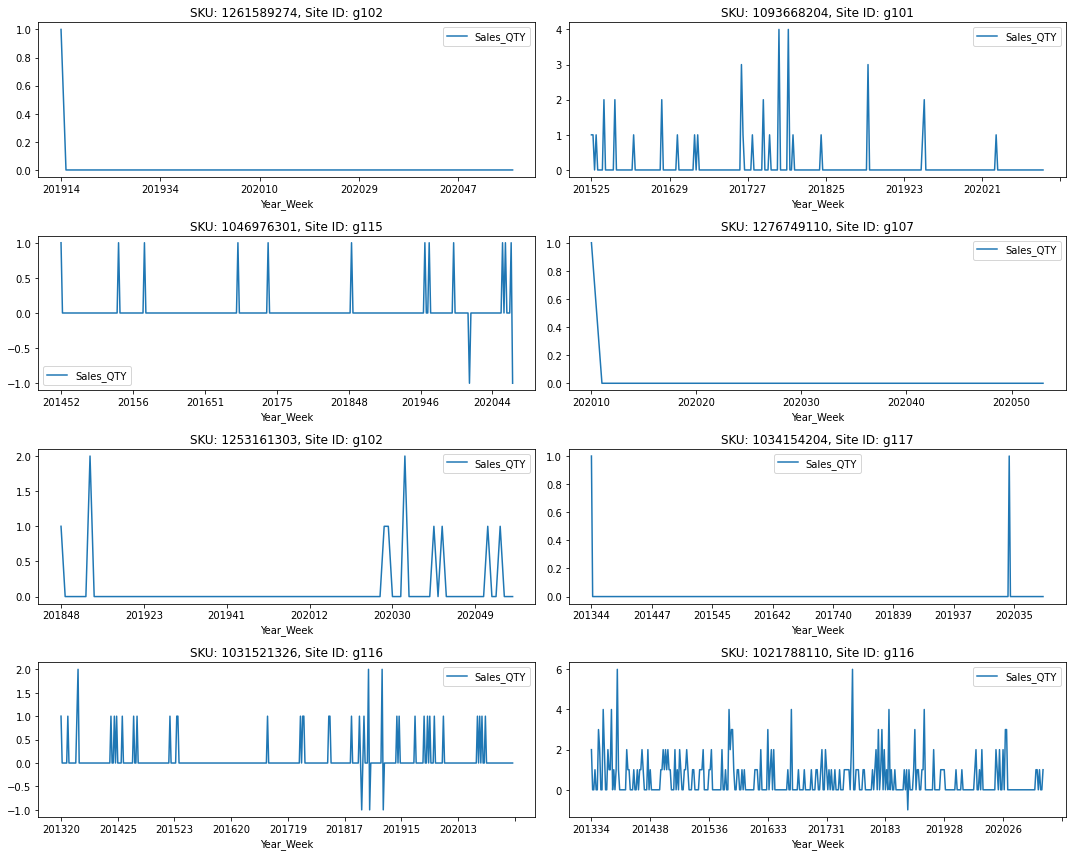

In [28]:
n_series = 8

# Sample n random occurences
samples = df[['SKU', 'Site_ID']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for article, site in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])
    ax_idx += 1
    
plt.tight_layout()
plt.show()

# Plot Time Series for Top-Sellers

In [29]:
# Get SKU / Store combinations with a mean sale greater a threshold
top_sellers_mean = df[['Site_ID', 'SKU', 'Sales_QTY']].groupby(['Site_ID', 'SKU']).mean() 
top_sellers_mean = top_sellers_mean.loc[top_sellers_mean.Sales_QTY > 0.2]
top_sellers_mean

Sales_QTY
Site_ID SKU                  
g101    2069466      0.202186
        2069474      1.005254
        2069482      1.012195
        2069490      0.262324
        2069505      0.416376
...                       ...
g590    1288779503   0.666667
        1288934412   0.500000
        1288934413   1.000000
        1288934415   0.500000
        1289959504   1.000000

[5559 rows x 1 columns]

In [30]:
# Get SKU / Store combinations which timeseries is longer than a threshold
top_sellers_length = df[['Site_ID', 'SKU', 'Sales_QTY']].loc[df.Sales_QTY > 0].groupby(['Site_ID', 'SKU']).count()
top_sellers_length = top_sellers_length.loc[top_sellers_length.Sales_QTY > 8]
top_sellers_length

Sales_QTY
Site_ID SKU                  
g101    2069466            55
        2069474           205
        2069482           158
        2069490            62
        2069505            99
...                       ...
g590    1282538101         11
        1282538301          9
        1283465804          9
        1284233102          9
        1284234802          9

[7506 rows x 1 columns]

In [31]:
# select only SKUs that meet both requirements 
top_sellers = top_sellers_mean.merge(top_sellers_length, how='inner', on=['Site_ID', 'SKU'])
top_sellers = top_sellers.reset_index(drop=False)[['Site_ID', 'SKU']]
top_sellers

,Site_ID,SKU
0,g101,2069466
1,g101,2069474
2,g101,2069482
3,g101,2069490
4,g101,2069505
...,...,...
1934,g590,1282538101
1935,g590,1282538301
1936,g590,1283465804
1937,g590,1284233102


In [32]:
# Print number of articles that are top sellers (it at least one store)
len(top_sellers.SKU.drop_duplicates())

742

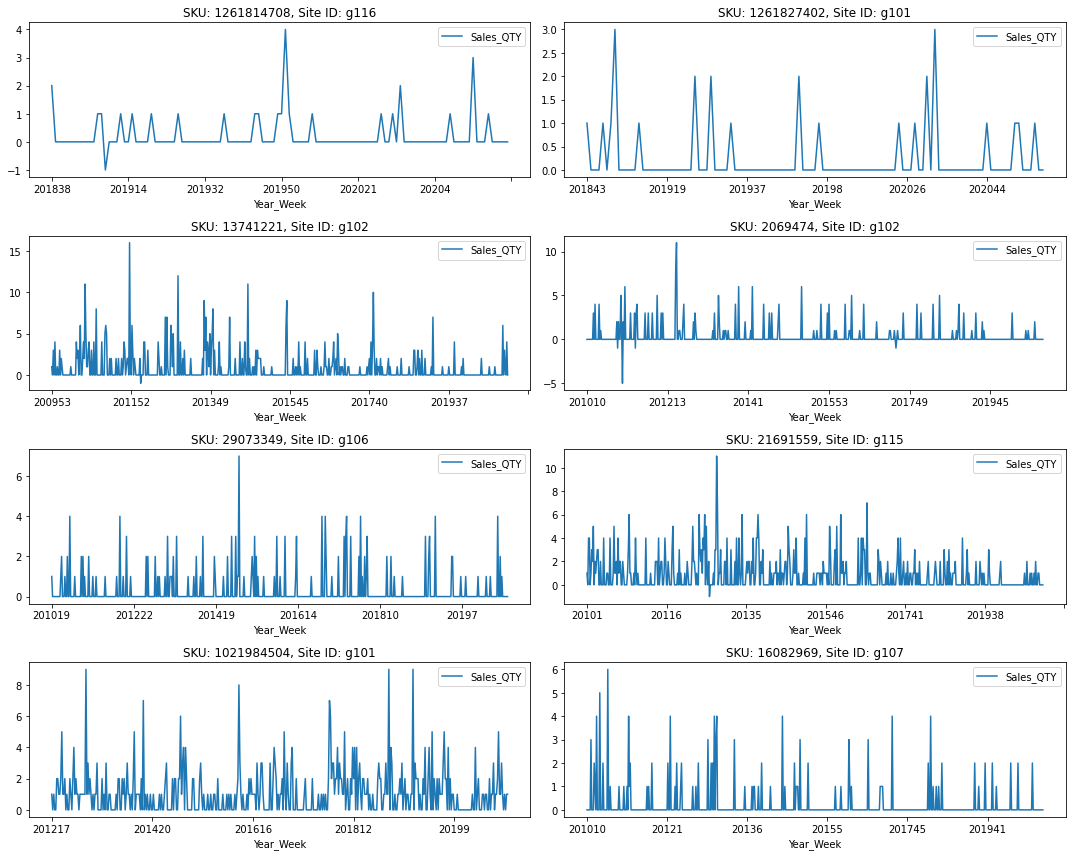

In [33]:
n_series = 8


# Sample n random occurences
samples = top_sellers.sample(n=n_series, random_state=1).values.tolist()

# Plot time series
fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
axs = axs.flatten()
ax_idx = 0


for site, article in samples:
    df_article = df.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Year_Week').reset_index()

    df_article.plot(x='Year_Week',
                 y='Sales_QTY',
                 title= f'SKU: {article}, Site ID: {site}',
                 ax=axs[ax_idx])

    ax_idx += 1
    
plt.tight_layout()
plt.show()
